# Store Sales - Time Series Forecasting

The evaluation metric is the Root Mean Squared Logarithmic Error 
$$RMSLE(\hat{y},y)=\sqrt{\frac{1}{n}\sum_{i=1}^n(\log(1+\hat{y}_i)-\log(1+y_i))^2}=RMSE\bigg(\log(1+\hat{y}),\log(1+y)\bigg)$$
For this reason we will take the target $z$ and transform it into a new target $y=\log(1+z)$. Then we will train our model to learn $y$ using as evaluation metric the RMSE, getting $\hat{y}$, then transform back as $\hat{z}=e^{\hat{y}}-1$

### Imports

In [298]:
import pandas as pd
from pathlib import Path
import numpy as np

from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

### Utilities

In [299]:
def autoregressive_forecast(model, df_model_test, features, lags=(1, 7, 14, 28)):
    """
    Perform day-by-day autoregressive forecasting.
    
    Parameters
    ----------
    model : trained model
        Model trained on log-transformed target (log1p(sales)).
    df_model_test : pd.DataFrame
        Test set containing lag features and other predictors.
    features : list
        List of feature column names used for prediction.
    lags : tuple of int
        Lag periods to update (default: (1, 7, 14, 28)).

    Returns
    -------
    pd.DataFrame
        Copy of df_model_test with columns:
        - 'pred': predicted log-sales
        - 'sales': predicted sales in original scale
        - updated lag features
    """

    df_pred = df_model_test.copy()
    df_pred['pred'] = np.nan
    test_dates = sorted(df_pred['date'].unique())
    key_cols = ['store_nbr', 'family']

    for date in test_dates:
        mask_day = df_pred['date'] == date
        X_day = df_pred.loc[mask_day, features].copy()

        preds = model.predict(X_day)
        df_pred.loc[mask_day, 'pred'] = preds

        # update lag features for future days
        for lag in lags:
            target_date = date + pd.Timedelta(days=lag)
            if target_date in df_pred['date'].values:
                mask_future = df_pred['date'] == target_date

                df_future = df_pred.loc[mask_future, key_cols]
                df_today = df_pred.loc[mask_day, key_cols].copy()
                df_today['pred_val'] = preds

                merged = pd.merge(df_future, df_today, on=key_cols, how='left')
                df_pred.loc[mask_future, f'sales_lag_{lag}'] = np.expm1(merged['pred_val'].values)

    df_pred['sales'] = np.expm1(df_pred['pred'])
    return df_pred


In [300]:
def plot_validation_series(valid, df_pred, store_nbr, family):
    """
    Plot actual vs predicted sales for one (store_nbr, family) over the validation window.
    """
    mask_true = (valid['store_nbr'] == store_nbr) & (valid['family'] == family)
    df_true = valid.loc[mask_true, ['date', 'sales']].sort_values('date')

    mask_pred = (df_pred['store_nbr'] == store_nbr) & (df_pred['family'] == family)
    df_hat = df_pred.loc[mask_pred, ['date', 'sales']].rename(columns={'sales': 'pred_sales'}).sort_values('date')

    df_plot = pd.merge(df_true, df_hat, on='date', how='left')

    plt.figure(figsize=(8, 4))
    plt.plot(df_plot['date'], df_plot['sales'], label='Actual', color='black', lw=2)
    plt.plot(df_plot['date'], df_plot['pred_sales'], label='Predicted', color='tab:orange', lw=2, linestyle='--')

    plt.title(f'Store {store_nbr} • Family: {family}', fontsize=11, pad=10)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Sales', fontsize=9)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(frameon=False, fontsize=8)
    plt.tight_layout()
    plt.show()


### Data

In [301]:
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW_PATH = PROJECT_ROOT / "data" / "raw"

files = {
    "train": "train.csv",
    "test": "test.csv",
    "oil": "oil.csv",
    "holidays": "holidays_events.csv"
}

df_train, df_test, df_oil, df_holiday = [pd.read_csv(RAW_PATH / fname) for fname in files.values()]

## Feature engineering & Train/Val Split

In [302]:
# Add a column 'sales' to the test data frame (the target) filled with NaN. Now we can stack train and test together and easily compute the features for both
df_test['sales'] = np.nan

# Fix datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Save the first date in the test set, so we will know how to split back
first_test_date = df_test['date'].min() # we will use it later for splitting train and test

# Concatenate the two dataset 
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

# Change the type of the 'onpromotion' feature
df['onpromotion'] = df['onpromotion'].astype('float32') # important for speeding up training


#### Temporal features

In [303]:

# sort the df first for store number, than family product than date: all time series will be stacked
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# define lags for lagged features
lags = [1, 7, 14, 28]

# create a feature for each lag
for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    df[f'onpromo_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(lag)

# we add calendar features
df['dow'] = df['date'].dt.dayofweek # Day of the week (e.g. takes into account weekends)
df['dom'] = df['date'].dt.day # Number of the month (e.g. salaries are given twice a month)
df['month'] = df['date'].dt.month # Learns relevant month e.g. december for christmas
df[['dow','dom','month']] = df[['dow','dom','month']].astype('int16') 



#### Encode categories

In [304]:
# encode categorical
# IMPORTANT: train and validation as well as test contain the same categories so encoding now (before splitting) does not leak information
# We create a new feature containing encoded product family (cat 1, cat, 2 etc)
enc = OrdinalEncoder()
df['family_enc'] = enc.fit_transform(df[['family']]).astype('int16')

#### Taking into account earthquake event

In [305]:
# To make the model learn a decay effect after the earthquake event of April 16, 2016
# Adds a new column containing the number of days after the event
eq_day = '2016-04-16'
df['days_since_eq'] = (df['date'] - pd.Timestamp(eq_day)).dt.days
# reset to nan days before the earthquake to prevent a countdown and leak info
df.loc[df['days_since_eq'] < 0, 'days_since_eq'] = np.nan

#### Include oil prices

In [306]:
# Fix datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'])
# Change the column name to a more readable one
df_oil = df_oil.rename(columns={'dcoilwtico': 'oil_price'})

# There are several days that:
#  - Are not listed in df_oil (holes)
#  - Are listed but the oil price is NaN

# We consider all the dates appearing in the original dataset 
all_dates = pd.DataFrame({'date': df['date'].dropna().unique()})

# and we add new rows to df_oil with the missing dates, setting price to NaN
df_oil = pd.merge(all_dates, df_oil, on='date', how='left').sort_values('date').reset_index(drop=True)
 
# Propagate forward the last observed price (the first value was NaN so it remains)
df_oil['oil_price'] = df_oil['oil_price'].ffill()

# We merge with the original dataset: now every date has the last observed oil price (except the first one)
df = pd.merge(df, df_oil, on='date', how='left')

# lag_7 oil price feature
df['oil_price_lag_7'] = df['oil_price'].shift(7)


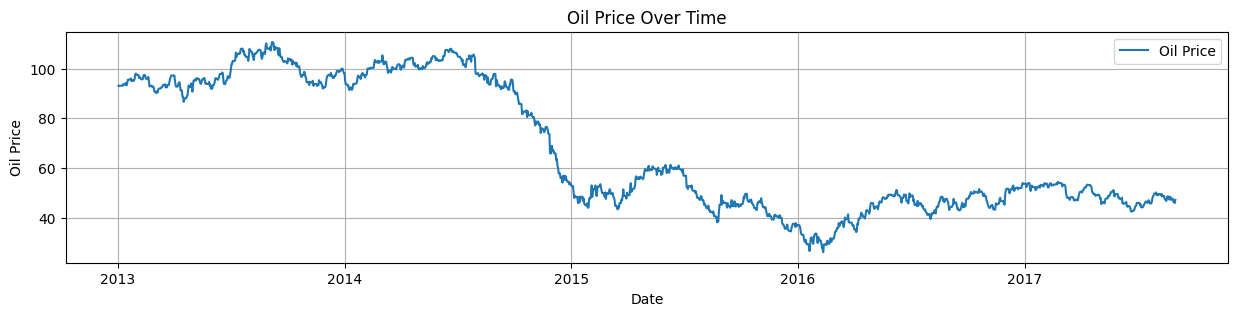

In [307]:
plt.figure(figsize=(15, 3))
plt.plot(df_oil['date'], df_oil['oil_price'], label='Oil Price')

plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Choose features and prepare final dataset

In [308]:

# choose features
lag_cols = [c for c in df.columns if c.startswith(('sales_lag_', 'onpromo_lag_','oil_price_lag_'))]
base_cols = ['onpromotion','store_nbr','family_enc','dow','dom','month','days_since_eq','oil_price']

features = lag_cols  + base_cols


### Train/Validation/Test split

In [309]:
# we make a copy of the dataset
df_model = df.copy()

# Get train and test with engineered features
df_model_train = df_model[df_model['date'] < first_test_date].copy() #  -> this goes into the training set
df_model_test  = df_model[df_model['date'] >= first_test_date].copy() # -> this goes into the test set





# Log target for RMSLE: we add a new column to the train set with the transformed target
target = 'target'
df_model_train[target] = np.log1p(df_model_train['sales']) # We will use this transformed version of 'sales' as target

# Split train/validation
validation_days = 50 # set the number of days used for validation (set to 0 if predictions are on test)
cutoff = df_model_train['date'].max() - pd.Timedelta(days=validation_days) # we cut the last 15 days of the training set
train = df_model_train[df_model_train['date'] <= cutoff] # we split the training set in proper training... 
valid = df_model_train[df_model_train['date'] > cutoff] # ... and validation

X_tr, X_va = train[features], valid[features] # features for train and validation
y_tr, y_va = train[target],  valid[target] # target for train and validation




In [310]:
# There is at least one nan feature for the first 28 days. We remove those features.
# However we must keep the nan's in the 'days_since_eq' column
allowed_nan = ['days_since_eq']
mask_tr = X_tr.drop(columns=allowed_nan, errors='ignore').notna().all(axis=1)
X_tr, y_tr = X_tr[mask_tr], y_tr[mask_tr]


## Training

In [311]:

model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    tree_method='hist',
    random_state=42,
    eval_metric='rmse'
)




In [312]:
model.fit(X_tr, y_tr, 
          eval_set=[(X_tr, y_tr)],   
          verbose=10)  

[0]	validation_0-rmse:2.61818
[10]	validation_0-rmse:1.96406
[20]	validation_0-rmse:1.48579
[30]	validation_0-rmse:1.14141
[40]	validation_0-rmse:0.89687
[50]	validation_0-rmse:0.72646
[60]	validation_0-rmse:0.61233
[70]	validation_0-rmse:0.53818
[80]	validation_0-rmse:0.49175
[90]	validation_0-rmse:0.46282
[100]	validation_0-rmse:0.44518
[110]	validation_0-rmse:0.43411
[120]	validation_0-rmse:0.42696
[130]	validation_0-rmse:0.42200
[140]	validation_0-rmse:0.41873
[150]	validation_0-rmse:0.41604
[160]	validation_0-rmse:0.41339
[170]	validation_0-rmse:0.41154
[180]	validation_0-rmse:0.40950
[190]	validation_0-rmse:0.40755
[200]	validation_0-rmse:0.40619
[210]	validation_0-rmse:0.40500
[220]	validation_0-rmse:0.40410
[230]	validation_0-rmse:0.40311
[240]	validation_0-rmse:0.40208
[250]	validation_0-rmse:0.40104
[260]	validation_0-rmse:0.40032
[270]	validation_0-rmse:0.39966
[280]	validation_0-rmse:0.39855
[290]	validation_0-rmse:0.39773
[300]	validation_0-rmse:0.39710
[310]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


<Axes: ylabel='feature'>

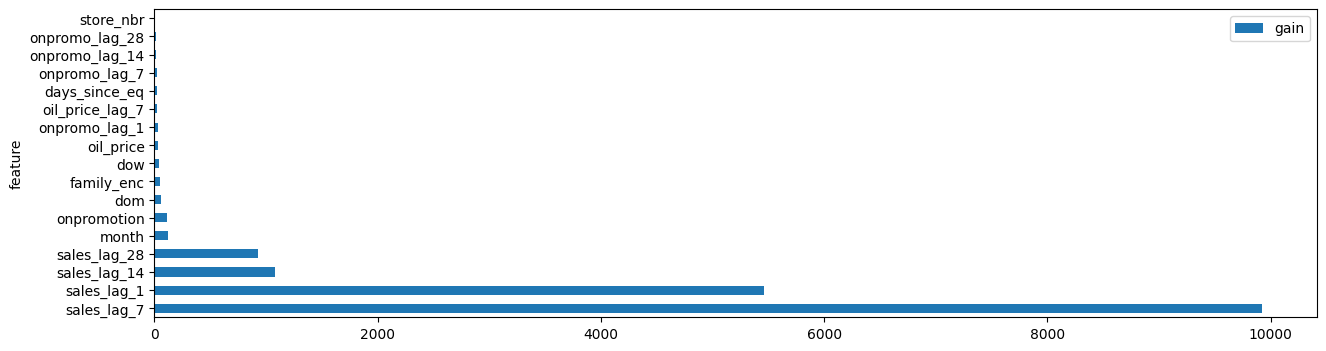

In [313]:
feat_names = X_tr.columns.tolist()
booster = model.get_booster()
score = booster.get_score(importance_type='gain')  # 'weight','gain','cover','total_gain','total_cover'
imp_gain = (pd.Series(score).rename_axis('feature')
            .reset_index(name='gain')
            .sort_values('gain', ascending=False))

# print(imp_gain.head(20))

imp_gain.head(30).plot(kind='barh', x='feature', y='gain', figsize=(15,4))


## Predictions and performance

In [314]:

df_pred = autoregressive_forecast(model, valid, features, lags=(1, 7, 14, 28))
pred_va= df_pred.loc[valid.index, 'sales'].values


In [315]:
pred_va_log = np.log1p(pred_va)

rmsle_val = np.sqrt(mean_squared_error(y_va.values, pred_va_log))
print(f"Validation RMSLE (roll-forward): {rmsle_val:.5f}")

Validation RMSLE (roll-forward): 0.46105


AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOOKS, BREAD/BAKERY, CELEBRATION, CLEANING, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, HARDWARE, HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE, LADIESWEAR, LAWN AND GARDEN, LINGERIE, LIQUOR,WINE,BEER, MAGAZINES, MEATS, PERSONAL CARE, PET SUPPLIES, PLAYERS AND ELECTRONICS, POULTRY, PREPARED FOODS, PRODUCE, SCHOOL AND OFFICE SUPPLIES, SEAFOOD


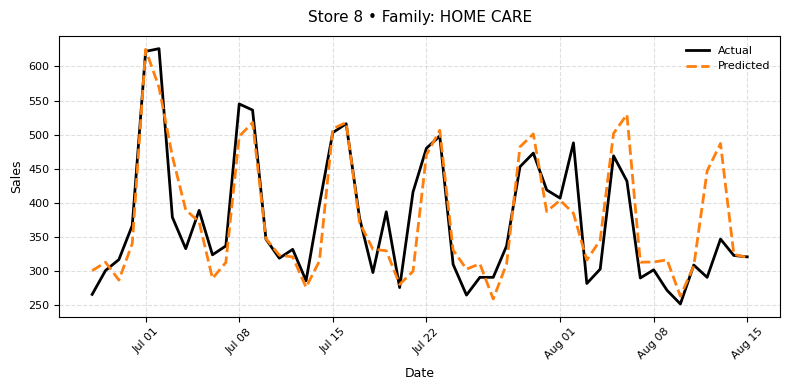

In [316]:
print(", ".join(sorted(df_model['family'].unique())))

df_val_pred = autoregressive_forecast(model, valid, features, lags=(1,7,14,28))
plot_validation_series(valid, df_val_pred, store_nbr=8, family='HOME CARE')


{'RMSLE': 0.4610521186305272, 'RMSE': 263.61235859516273, 'MAPE%': 32.054701924520565, 'R2': 0.9588568596369299}


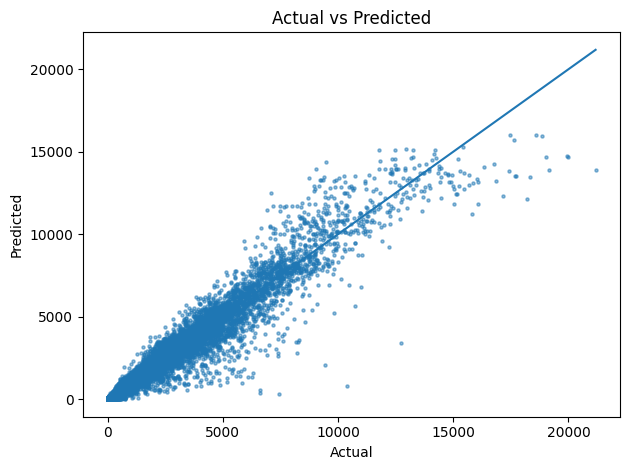

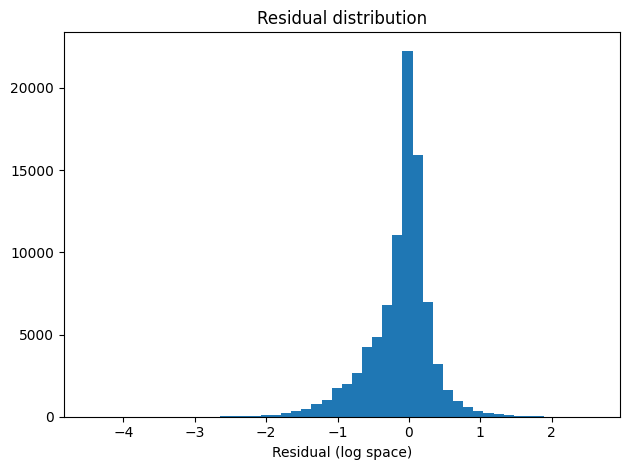

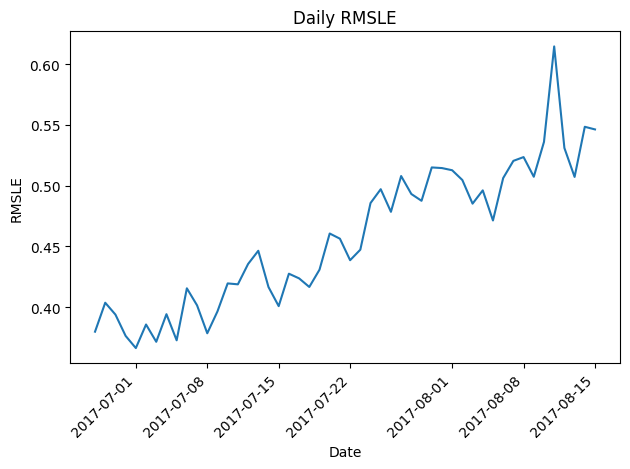

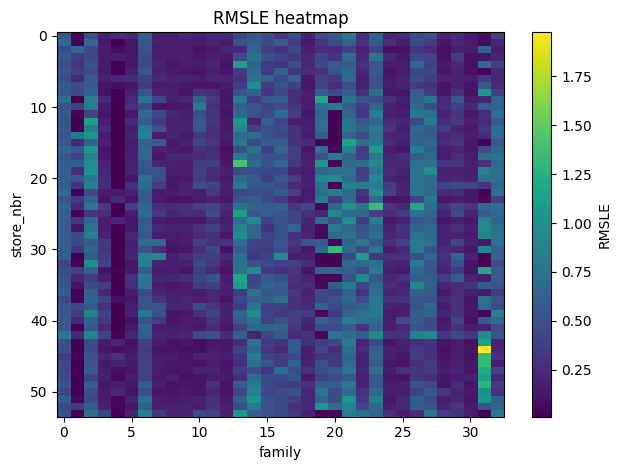

In [317]:

keys = ['date', 'store_nbr', 'family']

val = (
    valid[keys + ['sales']]
    .merge(
        df_val_pred[keys + ['sales']].rename(columns={'sales': 'pred'}),
        on=keys, how='left'
    )
    .sort_values(keys)
)

# Log-space targets
val['y_log']    = np.log1p(val['sales'])
val['yhat_log'] = np.log1p(val['pred'])

# Vectorized metrics
rmsle = np.sqrt(mean_squared_error(val['y_log'], val['yhat_log']))
rmse  = np.sqrt(np.mean((val['pred'] - val['sales'])**2))
mape  = 100 * np.mean(np.abs(val['pred'] - val['sales']) / np.clip(val['sales'], 1, None))
sst   = np.sum((val['sales'] - val['sales'].mean())**2)
sse   = np.sum((val['pred'] - val['sales'])**2)
r2    = 1 - sse / sst if sst > 0 else np.nan

print({'RMSLE': float(rmsle), 'RMSE': float(rmse), 'MAPE%': float(mape), 'R2': float(r2)})

# Residuals and helpers
val['res_log'] = val['yhat_log'] - val['y_log']
val['se_log']  = val['res_log']**2

# Daily RMSLE (no apply, no warning)
daily = (
    val.groupby('date', as_index=False)['se_log'].mean()
       .assign(rmsle=lambda d: np.sqrt(d['se_log']))
       .drop(columns='se_log')
)

# Series RMSLE by (store,family) (no apply)
seg = (
    val.groupby(['store_nbr','family'], as_index=False)['se_log'].mean()
       .assign(rmsle=lambda d: np.sqrt(d['se_log']))
       .drop(columns='se_log')
)

# ---- Plots ----

# 1) Actual vs Predicted
plt.figure()
plt.scatter(val['sales'], val['pred'], s=5, alpha=0.5)
lim = max(val['sales'].max(), val['pred'].max())
plt.plot([0, lim], [0, lim])
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Actual vs Predicted'); plt.tight_layout()

# 2) Residual histogram (log-space)
plt.figure()
plt.hist(val['res_log'].dropna(), bins=50)
plt.xlabel('Residual (log space)'); plt.title('Residual distribution'); plt.tight_layout()

# 3) Daily RMSLE
plt.figure()
plt.plot(daily['date'], daily['rmsle'])
plt.xlabel('Date'); plt.ylabel('RMSLE'); plt.title('Daily RMSLE'); plt.tight_layout()
# format dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 6) Heatmap of RMSLE by (store,family)
heat = seg.pivot(index='store_nbr', columns='family', values='rmsle')
plt.figure()
plt.imshow(heat, aspect='auto')
plt.colorbar(label='RMSLE')
plt.xlabel('family'); plt.ylabel('store_nbr'); plt.title('RMSLE heatmap'); plt.tight_layout()


